In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, auc
from uitils import *
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, recall_score, f1_score

In [15]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Data Loading

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, y_train = extract_samples(x_train, y_train, 500)
x_test, y_test = extract_samples(x_test, y_test, 100)
print("Reduced training set shape:", x_train.shape)
print("Reduced testing set shape:", x_test.shape)
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = y_train % 2  # Convert labels 0 (even) & 1 (odd) 
y_test = y_test % 2
s=y_train

# Initialize zeros, meaning all unlabeled
s = np.zeros_like(y_train)

# Select a 300 samples randomly where y_train == 1 to be labeled
positive_indices = np.where(y_train == 1)[0]
chosen_indices = np.random.choice(positive_indices, size=300, replace=False)

s[chosen_indices] = 1

# Mark the rest of the positive_indices except the chosen 300
rest_of_positives = np.setdiff1d(positive_indices, chosen_indices)

# From the rest, select 30%/50%/70% and labels as 0 in y_train
number_to_mark_unlabeled = int(len(rest_of_positives) * 0.03)
# number_to_mark_unlabeled = int(1) #
unlabeled_indices = np.random.choice(rest_of_positives, size=number_to_mark_unlabeled, replace=False)
y_train[unlabeled_indices] = 0

## Remove the rest of the positive rows that not in the chosen 300 & not marked as unlabeled
indices_to_drop = np.setdiff1d(rest_of_positives, np.concatenate([chosen_indices, unlabeled_indices]))
x_train_reduced = np.delete(x_train, indices_to_drop, axis=0)
y_train_reduced = np.delete(y_train, indices_to_drop)
# s = np.delete(s, indices_to_drop)

print("Training labels distribution:", np.bincount(y_train_reduced))
print("Training original labels distribution:", np.bincount(s))

Reduced training set shape: (5000, 28, 28)
Reduced testing set shape: (1000, 28, 28)
Training labels distribution: [2566  300]
Training original labels distribution: [4700  300]


# Pre-training

In [17]:
weight_decay = 2.0
model_1 = Sequential([
    Conv2D(128, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (1, 1), padding='same', kernel_regularizer=l2(weight_decay)),
    BatchNormalization(),
    Activation('relu'),
    Flatten(),
    Dense(16, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(10, kernel_regularizer=l2(weight_decay)),
    Activation('relu'),
    Dense(1, kernel_regularizer=l2(weight_decay)),
    Activation('sigmoid')
])


model_1.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit(x_train_reduced, y_train_reduced, epochs=15, batch_size=128, validation_split=0.2)
# model_1.save_weights('clf_model_.weights.h5')
# model_1.load_weights('clf_model_.weights.h5')


Epoch 1/15
18/18 [==============================] - 4s 171ms/step - loss: 349.9651 - accuracy: 0.8957 - val_loss: 348.1529 - val_accuracy: 0.8937
Epoch 2/15
18/18 [==============================] - 3s 175ms/step - loss: 345.9932 - accuracy: 0.8957 - val_loss: 344.2251 - val_accuracy: 0.8937
Epoch 3/15
18/18 [==============================] - 3s 165ms/step - loss: 342.1095 - accuracy: 0.8957 - val_loss: 340.3801 - val_accuracy: 0.8937
Epoch 4/15
18/18 [==============================] - 3s 168ms/step - loss: 338.3079 - accuracy: 0.8957 - val_loss: 336.6178 - val_accuracy: 0.8937
Epoch 5/15
18/18 [==============================] - 3s 163ms/step - loss: 334.5870 - accuracy: 0.8957 - val_loss: 332.9326 - val_accuracy: 0.8937
Epoch 6/15
18/18 [==============================] - 3s 174ms/step - loss: 330.9437 - accuracy: 0.8957 - val_loss: 329.3300 - val_accuracy: 0.8937
Epoch 7/15
18/18 [==============================] - 3s 160ms/step - loss: 327.3763 - accuracy: 0.8957 - val_loss: 325.7959 -

### Probablistic outcome of classifer to pre-train policy network
 

In [18]:
probabilities = model_1.predict(x_train_reduced)
threshold = min(probabilities[y_train_reduced == 1])
print(f"Threshold: {threshold}")
# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
clf_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(clf_predicted_labels))

90/90 [==============================] - 2s 15ms/step
Threshold: [0.30825207]
Classifer predicted labels distribution: [  14 2852]


32/32 [==============================] - 1s 17ms/step


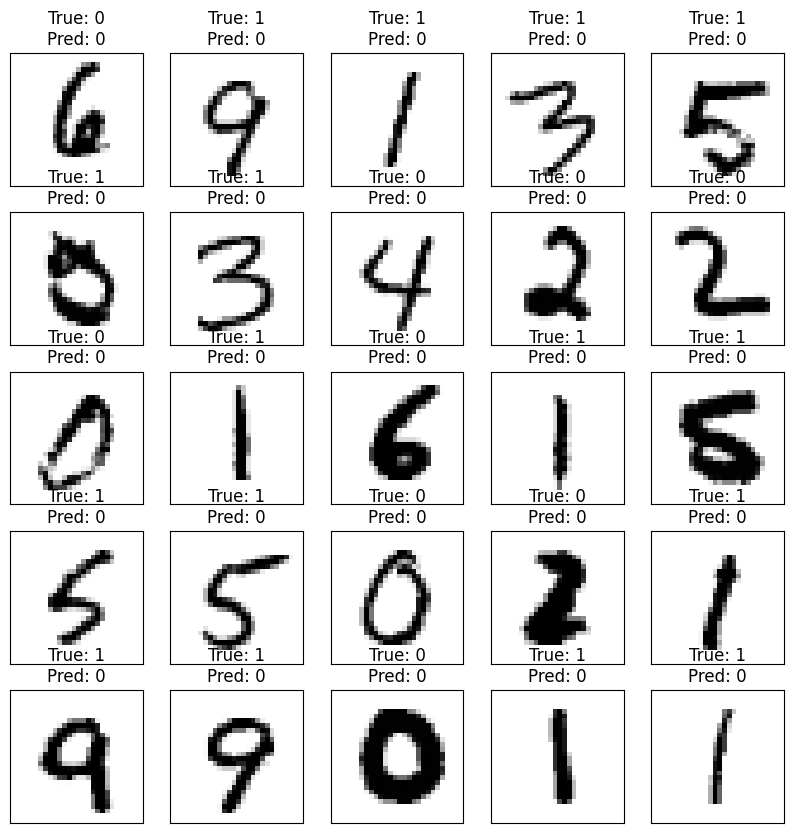

In [19]:
# print(list(probabilities))

# Predictions from the second classifier
predictions = model_1.predict(x_test)
predicted_classes = (predictions > 0.5).astype(int).flatten()  ### binary classification

# Selecting a few images to display
indices = np.random.choice(range(len(x_test)), 25, replace=False)  ###  select Randomly 25 images
selected_images = x_test[indices]
selected_labels = y_test[indices]
selected_predictions = predicted_classes[indices]

# Plotting
plot_images(selected_images, selected_labels, selected_predictions)

In [20]:
# Policy-Network Model

class PolicyGradientNetwork:
    def __init__(self):
        self.model = self._create_model()
    
    def _create_model(self):
        weight_decay = 0.5
        model = Sequential([
            Conv2D(96, (3, 3), padding='same', input_shape=(28, 28, 1), kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Flatten(),
            Dense(100, kernel_regularizer=l2(weight_decay)),
            Activation('relu'),
            Dense(10, kernel_regularizer=l2(weight_decay)),  # Additional Dense layer
            Activation('relu'),
            Dense(1, kernel_regularizer=l2(weight_decay)),  # Softmax output for binary classification
            Activation('sigmoid') # Hard labeling
        ])
        return model
    
    def get_model(self):
        return self.model
    

policy_network = PolicyGradientNetwork()
pn_model = policy_network.get_model()

pn_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

history_2 = pn_model.fit(x_train_reduced, clf_predicted_labels, epochs=15, batch_size=128, validation_split=0.2)
# pn_model.save_weights('pn_model_.weights.h5')
# pn_model.load_weights('pn_model_.weights.h5')

Epoch 1/15
18/18 [==============================] - 3s 136ms/step - loss: 147.9300 - accuracy: 0.9167 - val_loss: 145.1918 - val_accuracy: 0.9930
Epoch 2/15
18/18 [==============================] - 2s 122ms/step - loss: 142.8176 - accuracy: 0.9952 - val_loss: 140.1868 - val_accuracy: 0.9948
Epoch 3/15
18/18 [==============================] - 2s 123ms/step - loss: 137.9090 - accuracy: 0.9952 - val_loss: 135.3864 - val_accuracy: 0.9948
Epoch 4/15
18/18 [==============================] - 2s 121ms/step - loss: 133.2094 - accuracy: 0.9952 - val_loss: 130.7949 - val_accuracy: 0.9948
Epoch 5/15
18/18 [==============================] - 2s 115ms/step - loss: 128.7150 - accuracy: 0.9952 - val_loss: 126.4040 - val_accuracy: 0.9948
Epoch 6/15
18/18 [==============================] - 2s 112ms/step - loss: 124.4158 - accuracy: 0.9952 - val_loss: 122.2030 - val_accuracy: 0.9948
Epoch 7/15
18/18 [==============================] - 2s 114ms/step - loss: 120.3020 - accuracy: 0.9952 - val_loss: 118.1825 -

In [21]:
probabilities = pn_model.predict(x_train_reduced)
threshold = min(probabilities[y_train_reduced == 1])
print(f"Threshold: {threshold}")
# Convert probabilities to binary labels based on the threshold
predicted_labels = (probabilities >= threshold).astype(int)
np_predicted_labels = predicted_labels.flatten().astype(int)

print("Classifer predicted labels distribution:", np.bincount(np_predicted_labels))

90/90 [==============================] - 2s 18ms/step
Threshold: [0.6325823]
Classifer predicted labels distribution: [   0 2866]


## Interactive learning

In [22]:
import tensorflow as tf
import numpy as np

class Agent:
    def __init__(self, model, target_model, alpha=0.00001, gamma=0.99):
        self.gamma = gamma  # Discount factor
        self.lr = alpha  # Learning rate
        self.model = model  # Policy model
        self.target_model = target_model # target policy model
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []

    def choose_action(self, states, s, threshold=0.5):
        # Convert states to float32 tensor within the function
        states = tf.convert_to_tensor(states, dtype=tf.float32)
        probabilities = self.target_model(states)  # Make sure target model expects float32 input
        # action_sampler = tfp.distributions.Bernoulli(probs=probabilities, dtype=tf.float32)
        # actions = action_sampler.sample()
        # print(f"probabilities ={probabilities}")
        # actions = tf.cast(tf.random.uniform(tf.shape(probabilities)) < probabilities, tf.int32)

        inferred_labels = tf.cast(probabilities > threshold, tf.int32)       
        s = tf.reshape(s, tf.shape(inferred_labels))  # Ensuring s is the same shape as inferred_labels
        actions = tf.where(s == 1, 1, inferred_labels)
        actions = tf.squeeze(actions)  # This should correctly squeeze actions to shape (128,)
        return actions.numpy(), probabilities.numpy()


    def store_transition(self, states, actions, rewards):
        self.state_memory.extend(states)
        self.action_memory.extend(actions)
        self.reward_memory.extend(rewards)

    def learn(self):
        actions = np.array(self.action_memory)
        rewards = np.array(self.reward_memory)
        states = np.array(self.state_memory)

        # Calculate discounted rewards
        G = np.zeros_like(rewards)
        for t in range(len(rewards)):
            G_sum = 0
            discount = 1
            for k in range(t, len(rewards)):
                G_sum += rewards[k] * discount
                discount *= self.gamma
            G[t] = G_sum

        # Updating policy
        with tf.GradientTape() as tape:
            loss = 0
            for idx, (g, state) in enumerate(zip(G, states)):
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                probs = self.model(state, training=True)
                # action_probs = tfp.distributions.Bernoulli(probs=probs)
                # log_prob = action_probs.log_prob(actions[idx])
                # loss += -g * tf.reduce_sum(log_prob)
                action_probs = tf.where(actions[idx] == 1, probs, 1 - probs)
                log_prob = tf.math.log(action_probs)
                loss += -g * tf.reduce_sum(log_prob)

        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Clear memory
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []


In [23]:
# Clone policy model for stable target policy
target_policy_model = tf.keras.models.clone_model(pn_model)
target_policy_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[],
    'recall':[],
    'f1':[]
}
agent = Agent(pn_model,target_model=target_policy_model, alpha=0.00001, gamma=0.99)
# parameters
n_epochs = 300
n_epochs = 10
batch_size = 128 # batch size as you needed adj them

def shuffle_data(x_train, y_train, s):
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    return x_train[indices], y_train[indices], s[indices]

def create_mini_batches(x_train, y_train, s, batch_size):
    for start_idx in range(0, len(x_train) - batch_size + 1, batch_size):
        excerpt = slice(start_idx, start_idx + batch_size)
        yield x_train[excerpt], y_train[excerpt], s[excerpt]

def calculate_threshold(clf_probabilities, y_batch):
    # Identify indces of +ve examples
    positive_indices = (y_batch == 1)
    
    # Calculate threshmin from positive examples
    if np.any(positive_indices):
        threshmin = np.min(clf_probabilities[positive_indices])
    else:
        threshmin = 0  # Default value if no positive examples are present

    # Identify of U0 
    U0_indices = (clf_probabilities >= threshmin)
    
    # Calculate the final threshold using Equation 5
    if np.any(U0_indices):
        threshold = np.mean(clf_probabilities[U0_indices])
    else:
        threshold = threshmin  # Use threshmin if no samples meet the U0 criteria

    return threshold

def calculate_rewards(clf_probabilities, y_batch, threshold):
    # Reward calculation needs to consider whether predictions meet a certain threshold/ or
    # Positive examples above threshold or -ve examples below threshold get +ve rewards
    rewards = []
    for prob, actual in zip(clf_probabilities.flatten(), y_batch):
        if actual == 1 or (actual == 0 and prob >= threshold):
            reward = prob  
        else:
            reward = prob -1  # reward probability
        rewards.append(reward)
    return rewards

In [24]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = x_train / 255.0
# x_test = x_test / 255.0
# y_train = y_train % 2  # Convert labels 0 (even) & 1 (odd) 
# y_test = y_test % 2
# s=y_train

# print("training set shape:", x_train.shape)
# print("testing set shape:", x_test.shape)

In [25]:
def train_model(x_train, y_train, s, epochs=300, batch_size=128, min_delta=0.0001, patience=10):
    x_train = x_train.astype('float32')
    y_train = y_train.astype('float32')
    s = s.astype('float32')

    dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, s))
    dataset = dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

    ### early_stopping = EarlyStopping(monitor='val_accuracy', patience=patience, min_delta=min_delta, mode='max', restore_best_weights=True, verbose=1)

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0
        epoch_accuracy = 0
        batch_count = 0
        # first_iteration = True
        # threshold_pass = 0.5
        threshold = 0.5
        for x_batch, y_batch, s_batch in dataset:
            ## # Get actions and probabilities for the entire batch
            actions, probabilities = agent.choose_action(x_batch, s_batch, threshold=threshold)

            ## # Fit the model on the current batch and update history dict
            batch_history = model_1.fit(x_batch, actions, epochs=1, batch_size=len(x_batch), validation_split=0.2, verbose=0)
            history['batch_loss'].append(batch_history.history['loss'][0])
            history['batch_accuracy'].append(batch_history.history['accuracy'][0])
            epoch_loss += batch_history.history['loss'][0]
            epoch_accuracy += batch_history.history['accuracy'][0]
            batch_count += 1

            clf_probabilities = model_1.predict(x_batch)
            threshold = calculate_threshold(clf_probabilities, y_batch)
            rewards = calculate_rewards(clf_probabilities, y_batch, threshold)
            agent.store_transition(x_batch.numpy(), actions, rewards)
            agent.learn()
            # break
        first_iteration = True
        epoch_loss /= batch_count
        epoch_accuracy /= batch_count
        history['epoch_loss'].append(epoch_loss)
        history['epoch_accuracy'].append(epoch_accuracy)
        print(f"Epoch {epoch+1}: Loss = {epoch_loss}, Accuracy = {epoch_accuracy}")

        # early stopping condition
        # early stopping condition #
        ## if epoch > 0 and (history['epoch_accuracy'][-1] - history['epoch_accuracy'][-2]) < min_delta:
        ##     print("Early stopping triggered.")
        ##     break

        probabilities = model_1.predict(x_test)  # Ensure this is the probability of the positive class
        roc_auc = roc_auc_score(y_true=y_test, y_score=probabilities)
        history['ROC_AUC'].append(roc_auc)
        # #Predict probabilities for the positive class
        # #probabilities = model_1.predict(x_test)
        precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=probabilities)
        pr_auc = auc(recall, precision)
        history['PR_AUC'].append(pr_auc)
        # #predictions = (model_1.predict(x_test) > 0.5).astype(int)
        predictions = (probabilities > 0.5).astype(int)
        accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
        history['accuracy'].append(pr_auc)

        recall_value = recall_score(y_true=y_test, y_pred=predictions)
        history['recall'].append(recall_value)

        # Calculate F1 score
        f1 = f1_score(y_true=y_test, y_pred=predictions)
        history['f1'].append(f1)
        print("ROC AUC Score:", roc_auc)
        print("Accuracy Score:", accuracy)
        print("Precision-Recall AUC:", pr_auc)
        # print("Recall:", recall_value)
        print("F1 Score:", f1)
        

        if epoch % 3 == 0:
            print("Updating target policy...")
            agent.target_model.set_weights(agent.model.get_weights())


train_model(x_train=x_train, y_train=y_train, s=s)

Epoch 1/300
1/1 [==============================] - 0s 98ms/step
Epoch 1: Loss = 297.2479301452637, Accuracy = 0.01127450994681567
32/32 [==============================] - 1s 20ms/step
ROC AUC Score: 0.592368
Accuracy Score: 0.5
Precision-Recall AUC: 0.5805917607194431
F1 Score: 0.0
Updating target policy...
Epoch 2/300
1/1 [==============================] - 0s 95ms/step
Epoch 2: Loss = 290.7524139404297, Accuracy = 0.3159313740208745
32/32 [==============================] - 1s 18ms/step
ROC AUC Score: 0.61895
Accuracy Score: 0.536
Precision-Recall AUC: 0.5866515226663866
F1 Score: 0.2839506172839506
Epoch 3/300
1/1 [==============================] - 0s 87ms/step
Epoch 3: Loss = 284.7147605895996, Accuracy = 0.7504901930689811
32/32 [==============================] - 1s 16ms/step
ROC AUC Score: 0.601424
Accuracy Score: 0.549
Precision-Recall AUC: 0.6175788748768657
F1 Score: 0.38472032742155526
Epoch 4/300
1/1 [==============================] - 0s 93ms/step
Epoch 4: Loss = 278.911759185

In [26]:
import pickle
with open('history_2_FW.pkl', 'wb') as file:
    # Use pickle to dump the dictionary into the file
    pickle.dump(history, file)

with open('history_2_FW.pkl', 'rb') as file:
    # Load the dictionary back from the pickle file
    loaded_history = pickle.load(file)

# Verify the content
print(loaded_history)

{'epoch_loss': [297.2479301452637, 290.7524139404297, 284.7147605895996, 278.911759185791, 273.3275657653809, 267.9519317626953, 262.7744674682617, 257.78586654663087, 252.97657928466796, 248.3382183074951, 243.8623420715332, 239.5411117553711, 235.36692504882814, 231.33264350891113, 227.43138961791993, 223.65667724609375, 220.00245170593263, 216.46275672912597, 213.03216476440429, 209.70523529052736, 206.47710494995118, 203.34295120239258, 200.298348236084, 197.33895149230958, 194.46083641052246, 191.66018829345703, 188.93328628540038, 186.27678985595702, 183.6874786376953, 181.1622570037842, 178.69828109741212, 176.29281997680664, 173.94329605102538, 171.64728050231935, 169.40253791809081, 167.20686149597168, 165.0582389831543, 162.9547607421875, 160.89466285705566, 158.8762107849121, 156.8978542327881, 154.95811805725097, 153.05558433532715, 151.188956451416, 149.35698394775392, 147.5585563659668, 145.7924545288086, 144.0577194213867, 142.353430557251, 140.67874488830566, 139.032889

In [27]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, auc
# Predict probabilities for the positive class
probabilities = model_1.predict(x_test)  # Ensure this is the probability of the positive class
roc_auc = roc_auc_score(y_true=y_test, y_score=probabilities)
print("ROC AUC Score:", roc_auc)

# Predict class labels based on a threshold, typically 0.5 for binary classifiers
predictions = (model_1.predict(x_test) > 0.5).astype(int)
accuracy = accuracy_score(y_true=y_test, y_pred=predictions)
print("Accuracy Score:", accuracy)

# Predict probabilities for the positive class
probabilities = model_1.predict(x_test)
precision, recall, _ = precision_recall_curve(y_true=y_test, probas_pred=probabilities)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

32/32 [==============================] - 1s 22ms/step
ROC AUC Score: 0.364178
32/32 [==============================] - 1s 21ms/step
Accuracy Score: 0.5
32/32 [==============================] - 1s 21ms/step
Precision-Recall AUC: 0.4082198173994103


In [16]:
target_policy_model.save_weights('target_policy_model_2.weights.h5')
model_1.save_weights('clf_model_after_IL_2.weights.h5')

history = {
    'epoch_loss': [],
    'epoch_accuracy': [],
    'batch_loss': [],
    'batch_accuracy': [],
    'predictions': [],
    'rewards': [],
    'thresholds': [],
    'ROC_AUC': [],
    'accuracy':[],
    'PR_AUC':[]
}

# Visual

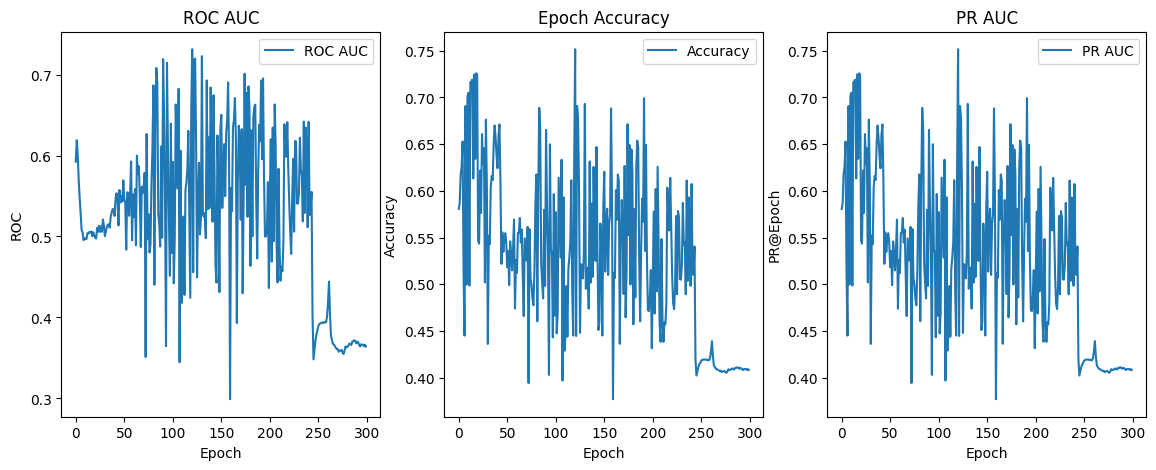

In [28]:
# Plotting epoch losses and accuracies 'ROC_AUC': [],
    # 'accuracy':[],
    # 'PR_AUC':[]
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history['ROC_AUC'], label='ROC AUC')
plt.title('ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.title('Epoch Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['PR_AUC'], label='PR AUC')
plt.title('PR AUC')
plt.xlabel('Epoch')
plt.ylabel('PR@Epoch')
plt.legend()
